# Testing DEMV on _German Credit_ dataset

- Positive label: credit=1
- Protected group: age=0, sex=0

In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity

import seaborn as sns

from utils import *
from demv import DEMV
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [3]:
data = pd.read_csv('data/german.csv', index_col=0)

In [4]:
data

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [5]:
label = 'credit'
positive_label = 1
sensitive_features = ['sex', 'age']
unpriv_group = {'sex': 0, 'age': 0}

In [6]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased data

In [7]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [8]:
print_metrics(bias_metrics)

Statistical parity:  -0.201  +-  0.139
Disparate impact:  0.743  +-  0.164
Zero one loss:  0.317  +-  0.117
F1 score:  0.731  +-  0.045
Accuracy score:  0.741  +-  0.044


## Exponentiated gradient

### Demographic parity

In [9]:
exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=DemographicParity(),
    sample_weight_name="classifier__sample_weight")

model, exp_metrics = cross_val(exponentiated_gradient, data.copy(), label, unpriv_group, sensitive_features, exp=True, positive_label=positive_label)

In [10]:
print_metrics(exp_metrics)

Statistical parity:  -0.042  +-  0.163
Disparate impact:  0.83  +-  0.119
Zero one loss:  0.224  +-  0.134
F1 score:  0.735  +-  0.032
Accuracy score:  0.747  +-  0.03


### Zero One Loss

In [11]:
constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)

In [12]:
exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=constr,
    sample_weight_name="classifier__sample_weight")

model, zero_one_metrics = cross_val(
    exponentiated_gradient, data.copy(), label, unpriv_group, sensitive_features, exp=True, positive_label=positive_label)


In [13]:
print_metrics(zero_one_metrics)

Statistical parity:  -0.284  +-  0.137
Disparate impact:  0.637  +-  0.179
Zero one loss:  0.328  +-  0.161
F1 score:  0.732  +-  0.042
Accuracy score:  0.74  +-  0.039


## DEMV

In [14]:
demv_data = data.copy()
demv = DEMV(round_level=1)

In [15]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [16]:
print_metrics(demv_metrics)

Statistical parity:  -0.124  +-  0.153
Disparate impact:  0.809  +-  0.153
Zero one loss:  0.259  +-  0.127
F1 score:  0.738  +-  0.038
Accuracy score:  0.75  +-  0.035


## DEMV evaluation

In [17]:
metrics = eval_demv(2, demv.get_iters(), data.copy(), pipeline, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [18]:
df = prepareplots(metrics,'german')

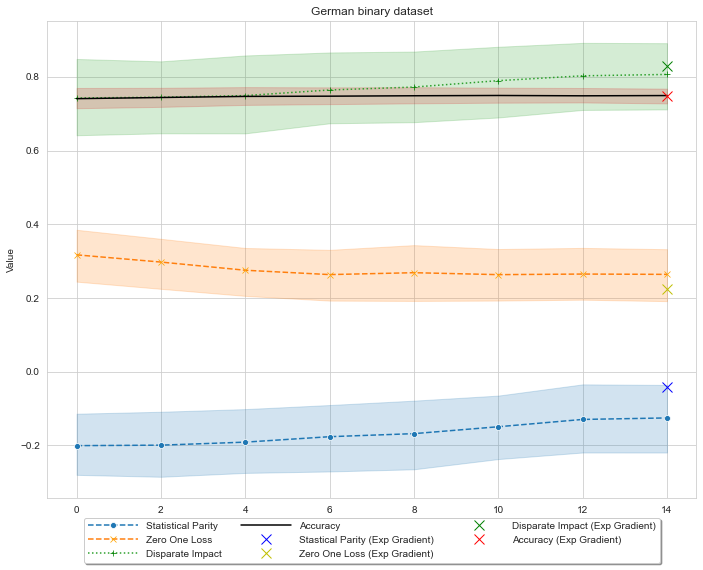

In [21]:
points = preparepoints(exp_metrics,demv.get_iters())

plot_metrics_curves(df, points, 'German binary dataset')

In [22]:
unprivpergentage(data,unpriv_group, demv.gest_iters())

Dataset size: 1000
Unprivileged group size: 105
Percentage of unprivileged group: 10.5
Number of iterations: 14
